In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image
import numpy as np

from numba import jit, prange

@jit(nopython=True, parallel=True)
def convert_images(ds_full: np.ndarray):
    images = np.empty((len(ds_full), 100, 100), dtype=np.uint8)
    for i in prange(len(ds_full)):
        img = ds_full[i].numpy()
        img = Image.fromarray(img)
        img = img.resize((100, 100))
        img = img.convert('L')
        images[i] = np.array(img)
    
    return images

def load_data(size=100, lim=100, use_jit=False):
    import deeplake

    # Load the FFHQ dataset
    ds = deeplake.load("hub://activeloop/ffhq")

    ds_full = ds['images_1024']['image'][:lim].numpy()

    if use_jit:
        images = convert_images(ds_full)
        return images

    images = np.empty((len(ds_full), size, size), dtype=np.uint8)
    for i in prange(len(ds_full)):
        img = ds_full[i]
        img = Image.fromarray(img)
        img = img.resize((size, size))
        img = img.convert('L')
        images[i] = np.array(img)

    return images


In [69]:
BASE_OUTPUT_FOLDER = os.path.join('results', 'q2')

In [3]:
size_img = 100
X = load_data(size=size_img, lim=4*size_img)
num_samples, img_height, img_width = X.shape
X = X.reshape(num_samples, img_height * img_width)
print(f"Image max: {X.max()}, Image min: {X.min()}")
X = X / X.max()

/home/mauro/miniconda3/envs/disciplinas/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


hub://activeloop/ffhq loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/ffhq


In [82]:
print(X.shape)

(400, 10000)


In [83]:
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

covariance_matrix = np.cov(X_centered, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [84]:
print(eigenvalues.shape)

(10000,)


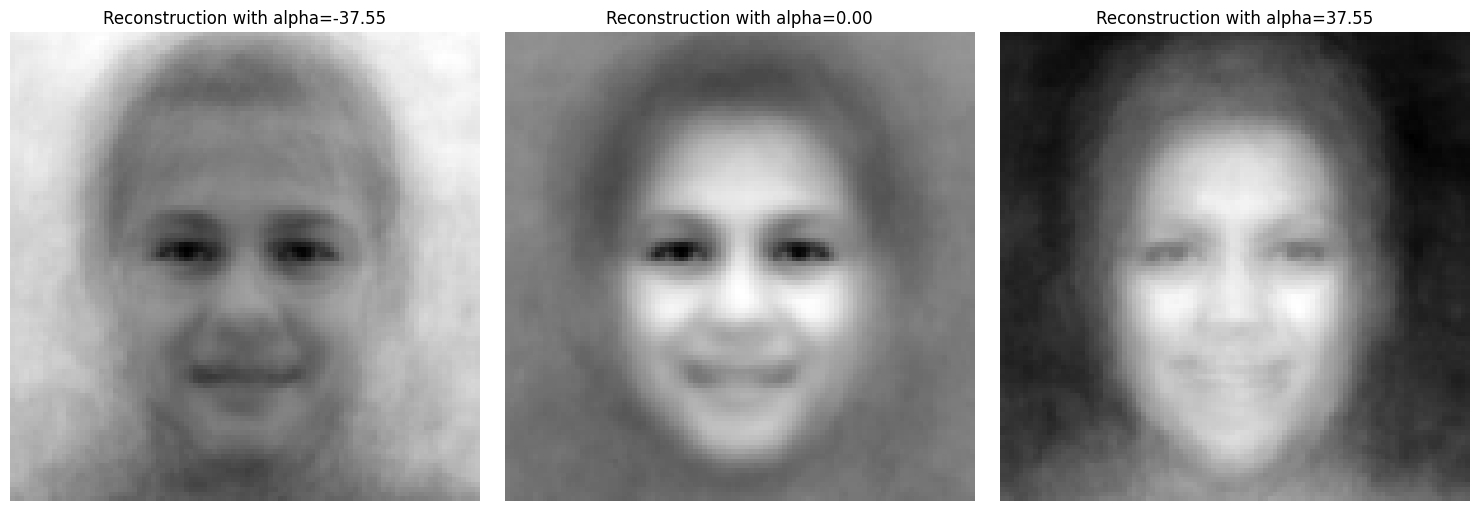

In [85]:
principal_components = eigenvectors

beta = 3
alpha_values = [-beta * np.sqrt(eigenvalues[0]), 0, beta * np.sqrt(eigenvalues[0])]

plt.figure(figsize=(15, 5))
for i, alpha in enumerate(alpha_values):
    reconstructed = X_mean + alpha * principal_components[:, 0]
    reconstructed_image = reconstructed.reshape(size_img, size_img)  # Reshape to image
    plt.subplot(1, 3, i + 1)
    plt.imshow(reconstructed_image, cmap="gray")
    plt.title(f"Reconstruction with alpha={alpha:.2f}")
    plt.axis('off')
plt.tight_layout()

plt.savefig(f'results/q2/reconstruction_beta_{beta}.png',bbox_inches='tight')
plt.show()

# Resolução (b)
Autovalores da matriz de convariância

Eigenvalues are 0 from index 399


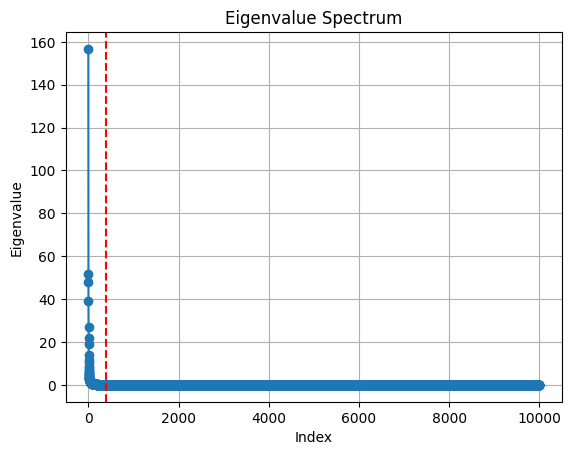

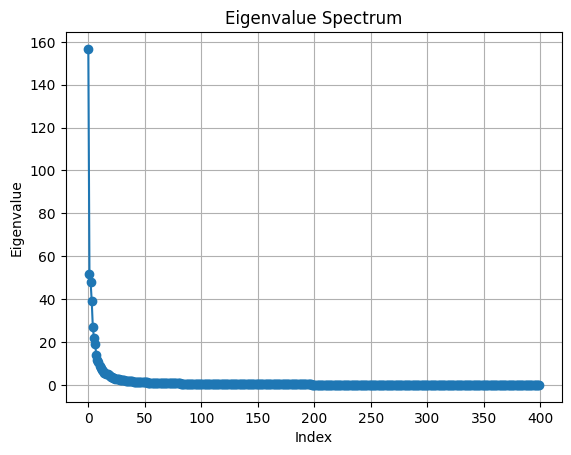

In [86]:
for i in range(eigenvalues.shape[0]):
    if eigenvalues[i] < 1e-5:
        break

print("Eigenvalues are 0 from index", i)

plt.figure()
plt.plot(eigenvalues, 'o-')
plt.title("Eigenvalue Spectrum")
plt.axvline(x=i, color='r', linestyle='--')
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid()
plt.savefig(f'results/q2/eigenvalues_full.png')
plt.show()


plt.figure()
plt.plot(eigenvalues[:400], 'o-')
# Show a line in x when the eigenvalues are 0

# plt.axhline(y=0, color='r', linestyle='--')
plt.title("Eigenvalue Spectrum")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid()
plt.savefig(f'results/q2/eigenvalues_limited.png')
plt.show()

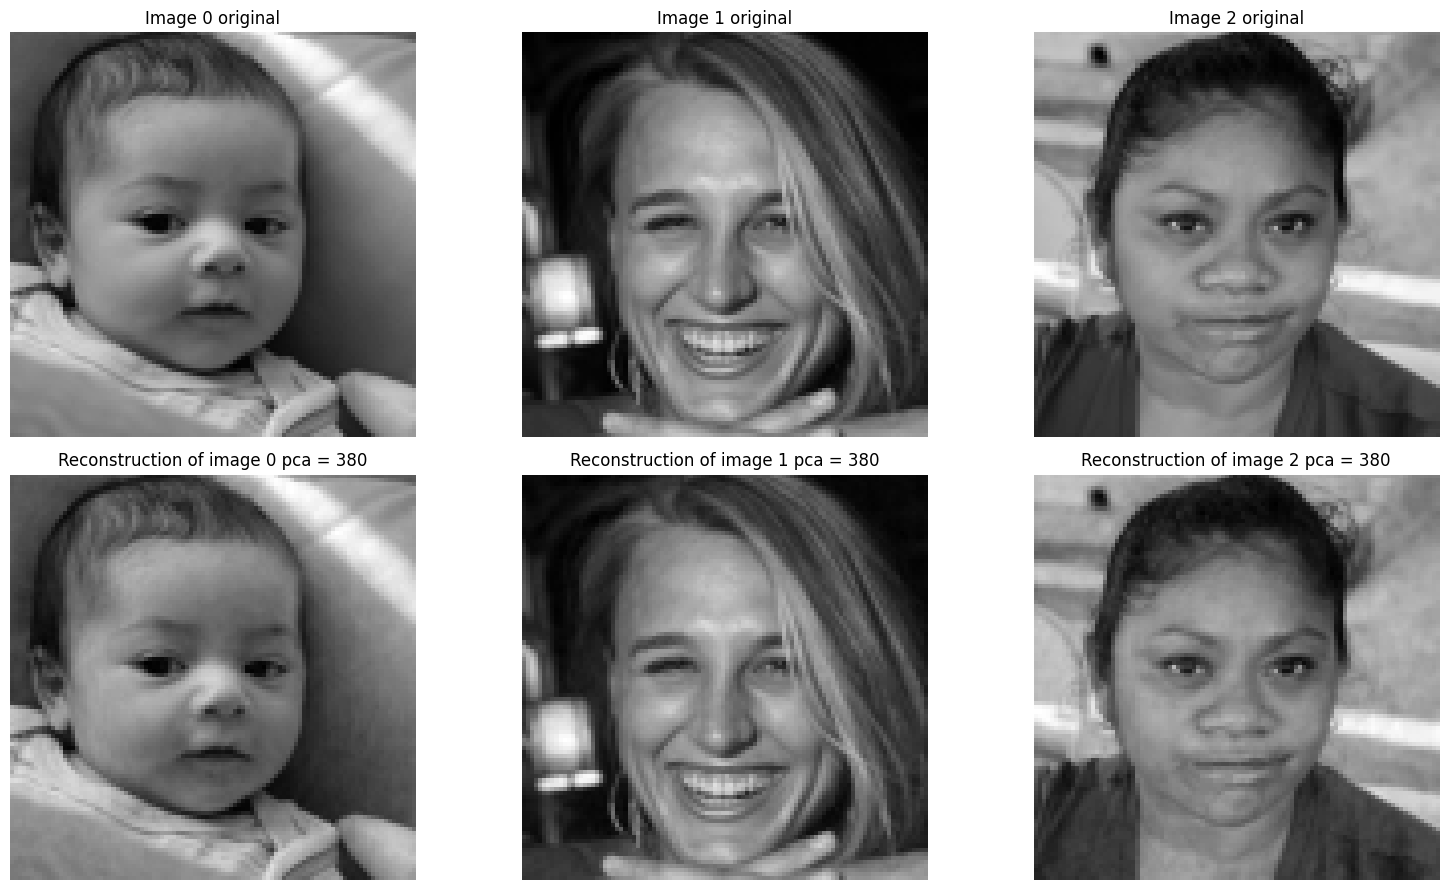

In [87]:
num_components = 380
principal_components = eigenvectors[:, :num_components]

X_projected = np.dot(X_centered, principal_components)

plt.figure(figsize=(16, 9))
for i in range(3):
    # reconstructed = X_mean + alpha * principal_components[:, 0]
    # reconstructed_image = reconstructed.reshape(size_img, size_img)  # Reshape to image
    X_reshaped = X[i].reshape(size_img, size_img)
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_reshaped, cmap="gray")
    plt.title(f"Image {i} original")
    plt.axis('off')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(15, 5))
for i in range(3):
    image_projected = X_projected[i]
    reconstructed_image = X_mean + np.dot(image_projected, principal_components.T)
    reconstructed_image = reconstructed_image.reshape(img_height, img_width)
    plt.subplot(2, 3, i + 3 + 1)
    plt.imshow(reconstructed_image, cmap="gray")
    plt.title(f"Reconstruction of image {i} pca = {num_components}")
    plt.axis('off')
plt.tight_layout()

plt.savefig(f'results/q2/reconstruction_from_pca_n_componenets_{num_components}', bbox_inches='tight')
plt.show()

# Resolução (c)

Gerador de Imagens

In [53]:
principal_components.shape

(10000, 380)

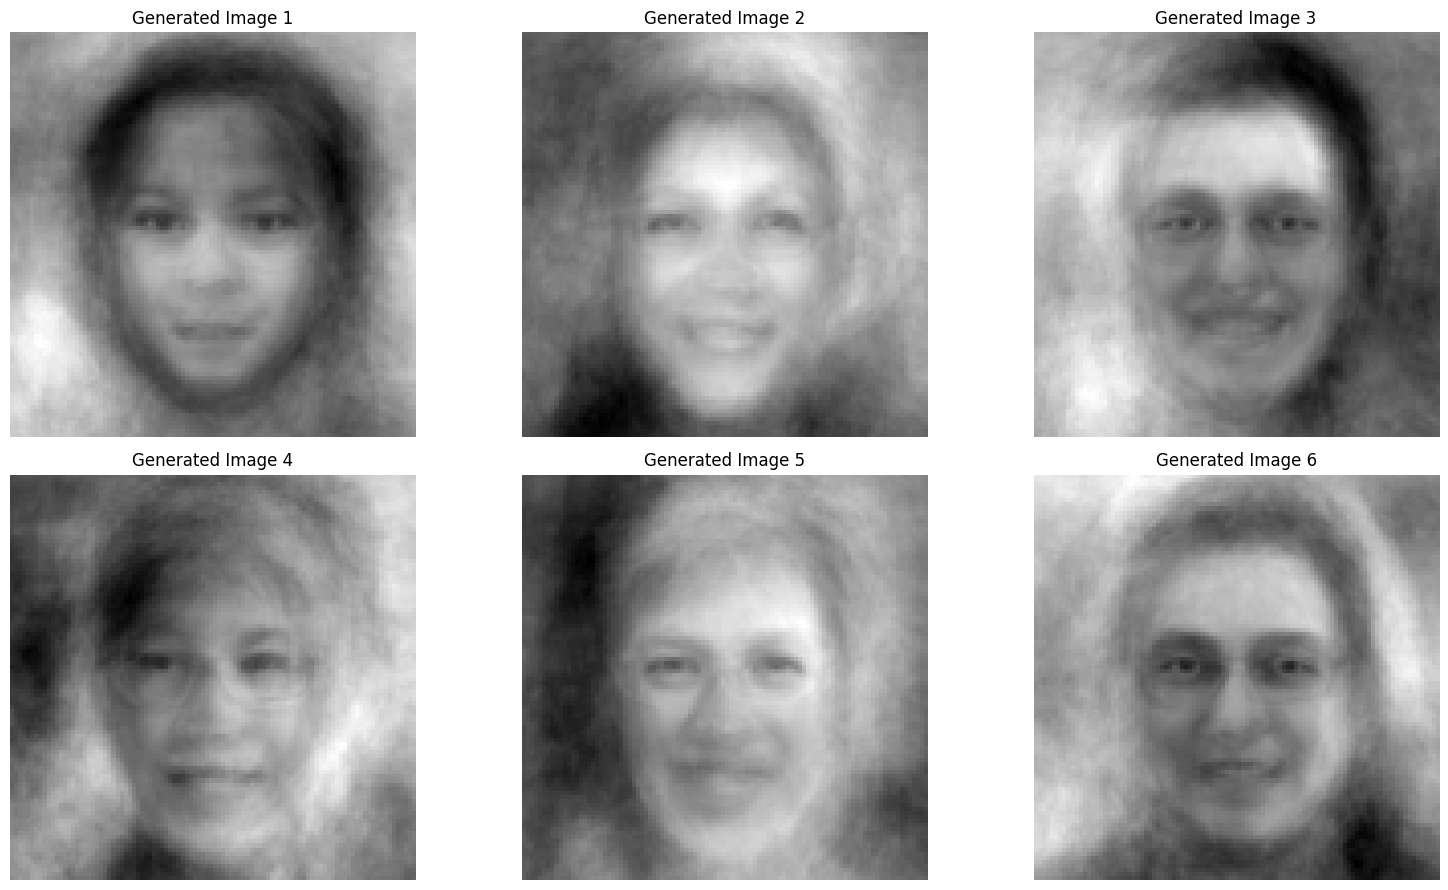

In [88]:
def generate_image(mean, components, eigenvalues, num_components, img_height, img_width):
    alphas = np.random.randn(num_components) * np.sqrt(eigenvalues[:num_components])
    generated_image = mean + np.dot(alphas, components.T)    
    return generated_image.reshape(img_height, img_width)

num_components = 30
num_images = 6
plt.figure(figsize=(16, 9))

for i in range(num_images):
    generated_image = generate_image(X_mean, principal_components[:, :num_components], eigenvalues, num_components, img_height, img_width)
    plt.subplot(2, 3, i + 1)
    plt.imshow(generated_image, cmap="gray")
    plt.title(f"Generated Image {i + 1}")
    plt.axis("off")

plt.tight_layout()

plt.savefig(os.path.join(BASE_OUTPUT_FOLDER, f'image_generator_results_n_components_{num_components}.png'), bbox_inches='tight')
plt.show()